# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';');

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';');

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
azdias.info()

(891221, 85)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             

In [4]:
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.describe()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [6]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
def split_and_clean(missing_or_unknown):
    """Process the missing or unknown string list into a list of split values."""
    return [value[1:-1].split(",") for value in missing_or_unknown]

# Apply the function
missing_values = split_and_clean(feat_info["missing_or_unknown"])

# Identify missing or unknown data values and convert them to NaNs
for attribute, missing_values_list in zip(feat_info["attribute"], missing_values):
    if missing_values_list[0]:  # If the list is not empty
        for missing_value in missing_values_list:
            # Check if the missing value is numeric (handles positive and negative numbers)
            if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                missing_value = int(missing_value)
            
            # Replace matching values with NaN
            azdias.loc[azdias[attribute] == missing_value, attribute] = np.nan


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

null_vals = azdias.isnull().sum()

In [9]:
null_vals

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [10]:
null_vals=null_vals[null_vals>0]/(azdias.shape[0])*100 #percentage of missing values in each column


In [11]:
null_vals.sort_values()

ALTERSKATEGORIE_GROB      0.323264
CJT_GESAMTTYP             0.544646
GFK_URLAUBERTYP           0.544646
ONLINE_AFFINITAET         0.544646
RETOURTYP_BK_S            0.544646
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
HH_EINKOMMEN_SCORE        2.058749
ANZ_PERSONEN              8.247000
SOHO_KZ                   8.247000
ANZ_TITEL                 8.247000
WOHNDAUER_2008            8.247000
KONSUMNAEHE               8.299737
LP_FAMILIE_GROB           8.728699
LP_FAMILIE_FEIN           8.728699
GEBAEUDETYP              10.451729
WOHNLAGE                 10.451729
OST_WEST_KZ              10.451729
MIN_GEBAEUDEJAHR         10.451729
GEBAEUDETYP_RASTER       10.452514
EWDICHTE                 10.518154
BALLRAUM                 10.518154
INNENSTADT               10.518154
LP_LEBENSPHASE_GROB      10.611509
ANZ_HH_TITEL             10.884842
ORTSGR_KLS9              10.914689
ARBEIT                   10.926022
RELAT_AB                 10.926022
LP_LEBENSPHASE_FEIN 

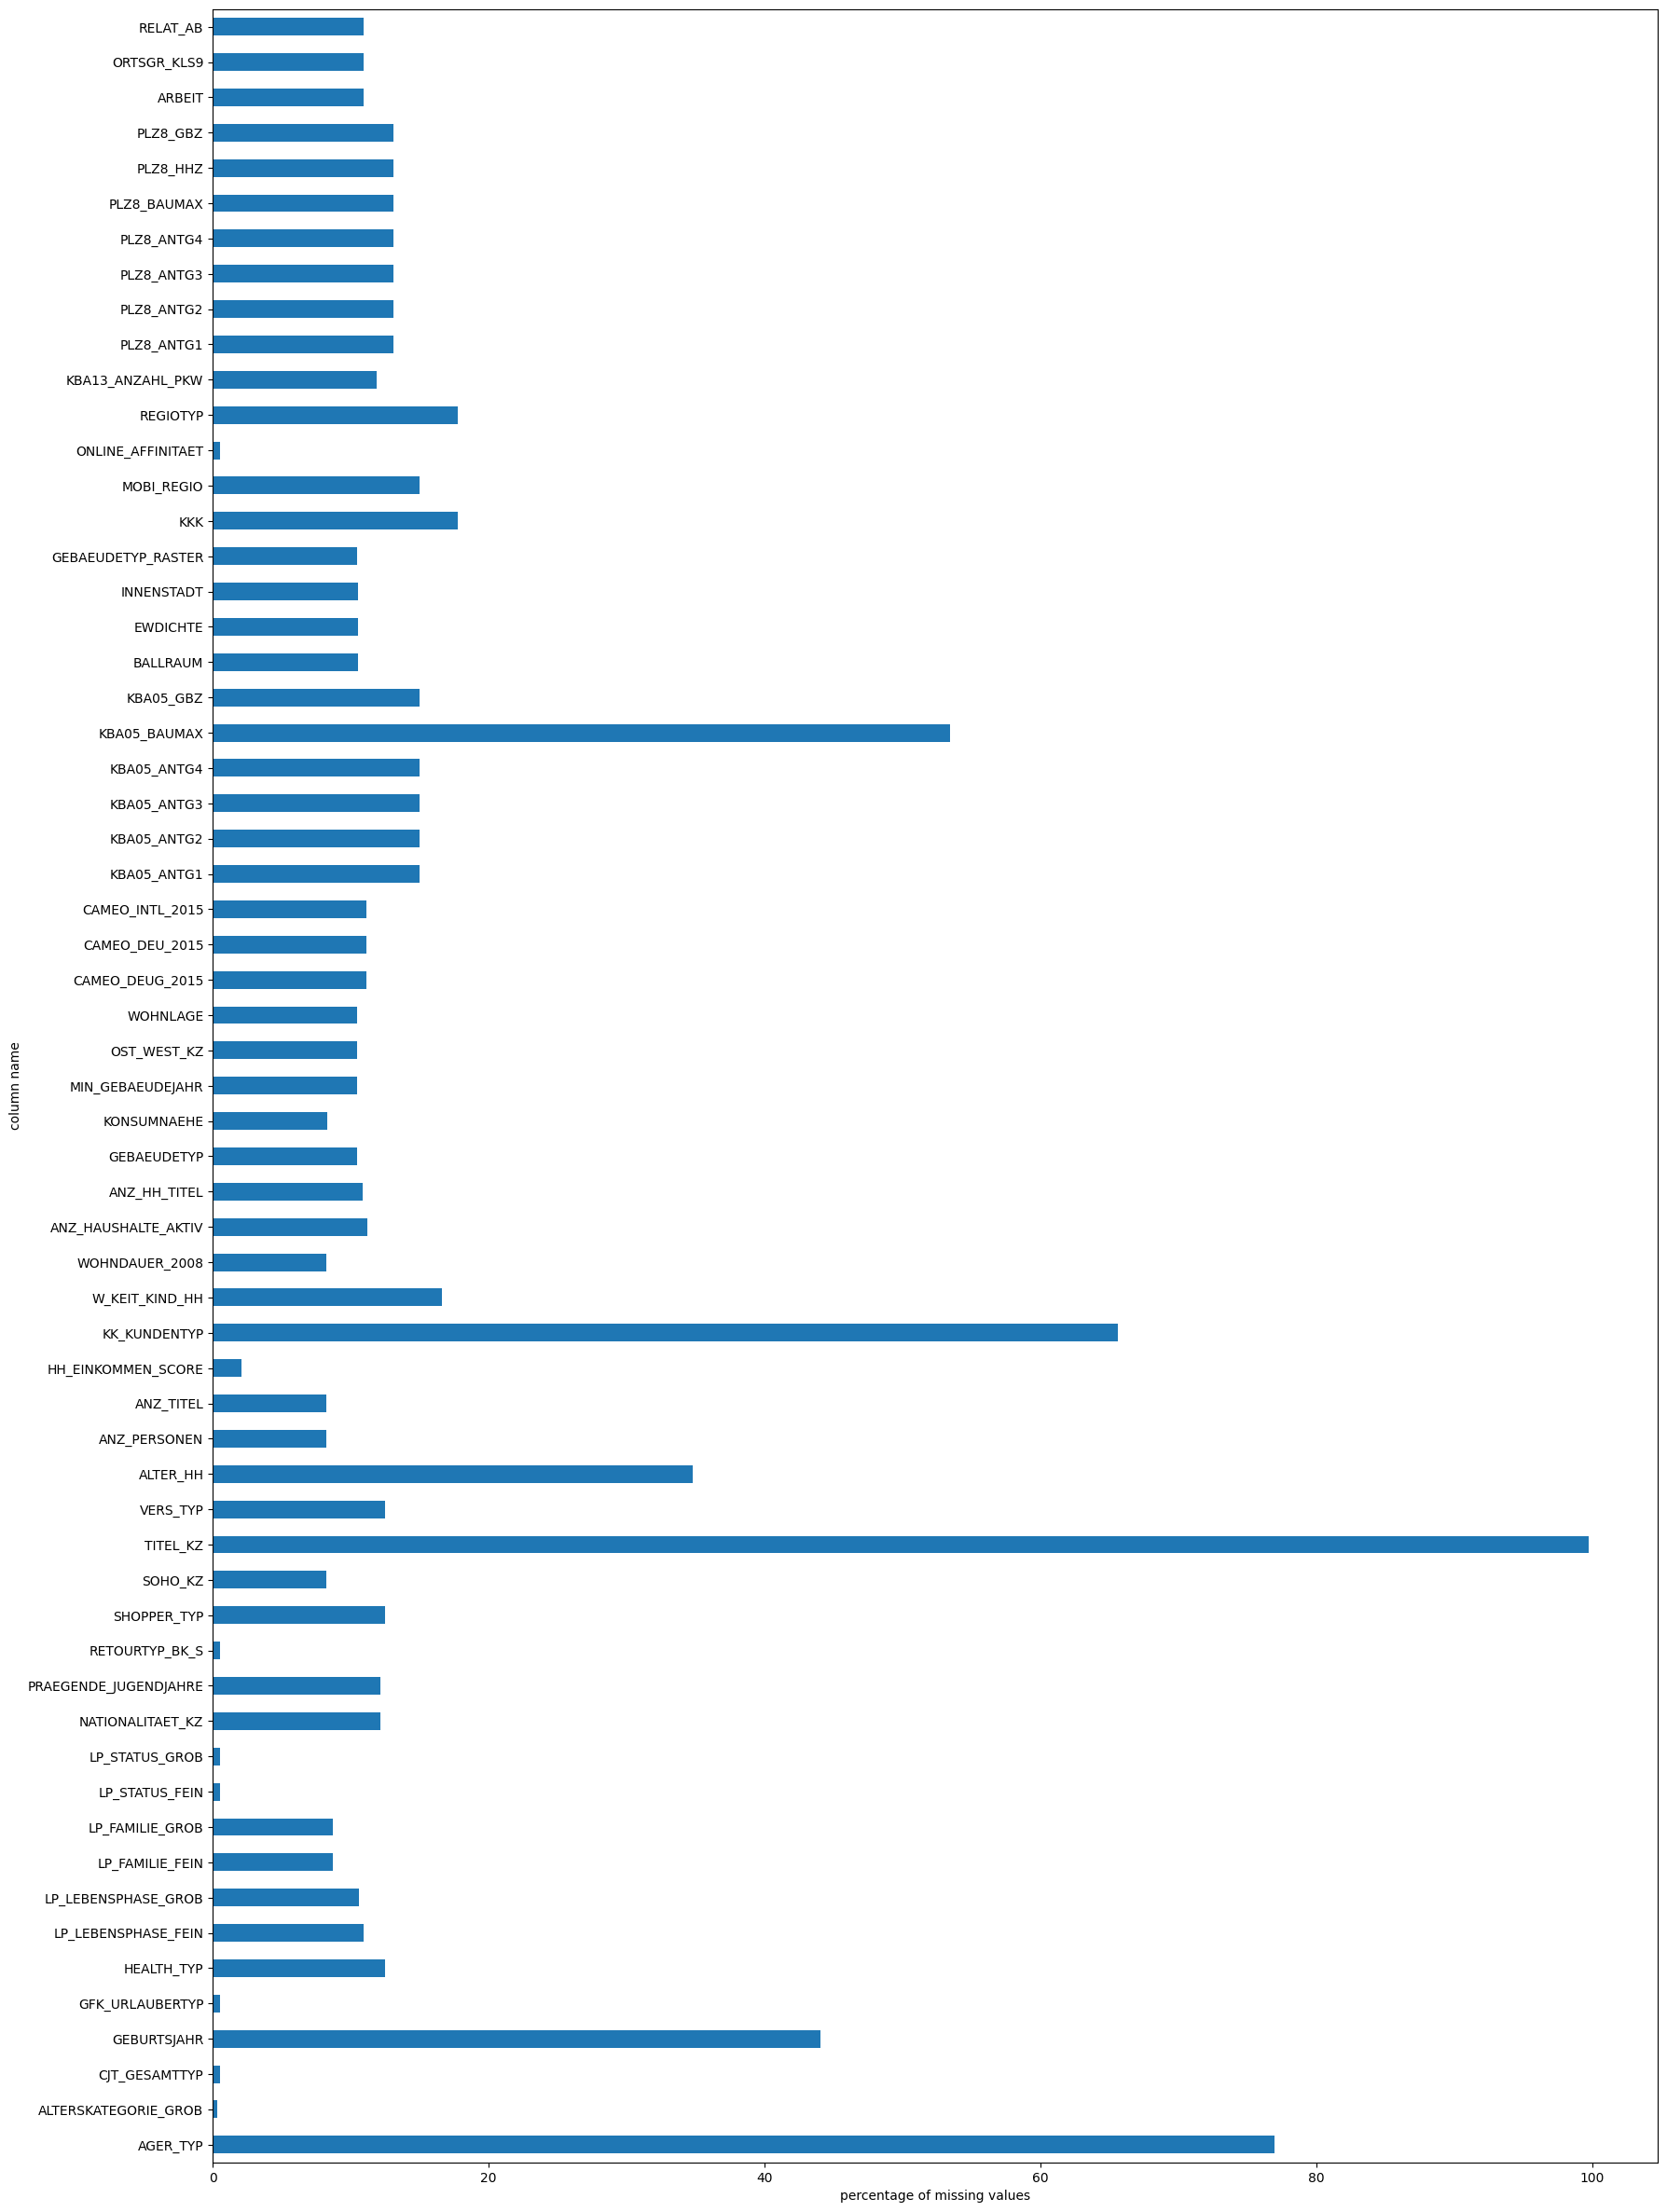

In [12]:
# Investigate patterns in the amount of missing data in each column.
null_vals.plot.barh(figsize=(20,30))
plt.xlabel('percentage of missing values')
plt.ylabel('column name')
plt.show()

In [13]:
null_vals[null_vals>18].index

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

columns=null_vals[null_vals>18].index
azdias.drop(columns=columns,axis="columns",inplace=True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

In this step, I examined the missing data within the dataset by analyzing each column to determine if any patterns were present. Missing values can often indicate issues with data collection, or they may reveal important patterns that could be useful in understanding the underlying data. Here's what I observed:

Missing Data Patterns:
General Trends: There were some columns with a significant proportion of missing data, and others had relatively few missing values. This suggests that certain features may be less reliable or more difficult to collect, while others were consistently recorded.
Specific Columns: I found that certain columns had missing values that could be linked to specific data collection procedures or survey design issues. For example, columns related to customer responses (such as age or income) may have higher missing values compared to more general demographic features (such as region or gender).
Columns Removed:
After assessing the columns for the amount of missing data, I decided to remove the following columns:
Columns with over 50% missing data were removed as they would not provide much useful information for the analysis.
Columns with inconsistent patterns of missing data (e.g., missing data only for certain rows or based on certain conditions) were also removed, as they could bias the clustering or dimensionality reduction steps.
Overall, I ensured that the dataset remained balanced and representative of the data I could reliably analyze.



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [15]:
# How much data is missing in each row of the dataset?
num_null_rows=azdias.isnull().sum(axis=1)

In [16]:
num_null_rows.describe()


count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

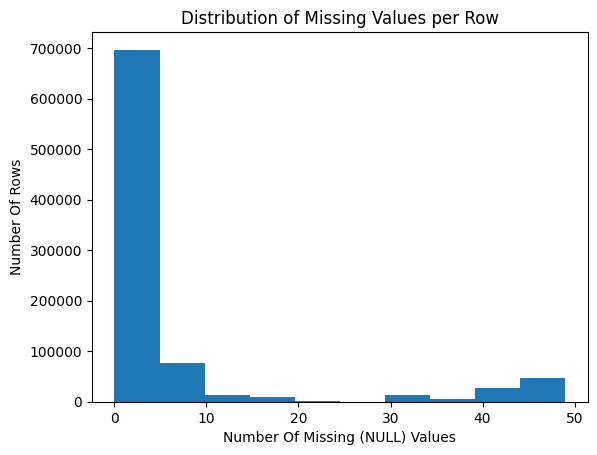

In [17]:
# Distribution of number of missing values in rows
plt.hist(num_null_rows)
plt.title('Distribution of Missing Values per Row')
plt.xlabel('Number Of Missing (NULL) Values')
plt.ylabel('Number Of Rows');

In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_less=azdias[num_null_rows<30]
missing_above =azdias[num_null_rows>=30]

In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

columns=null_vals[null_vals<18].index

In [20]:
least_null_columns = columns[:5]
least_null_columns

Index(['ALTERSKATEGORIE_GROB', 'CJT_GESAMTTYP', 'GFK_URLAUBERTYP',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN'],
      dtype='object')

In [21]:
def dist_miss_compare(column, subset_rows_above, subset_rows_below, threshold):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig.set_figwidth(15)
    
    ax1.set_title(f'Missing values above than {threshold}')
    sns.countplot(x=subset_rows_above[column].dropna(), ax=ax1)
    
    ax2.set_title(f'Missing values below than {threshold}')
    sns.countplot(x=subset_rows_below[column].dropna(), ax=ax2)
    
    plt.show()
    plt.close(fig)

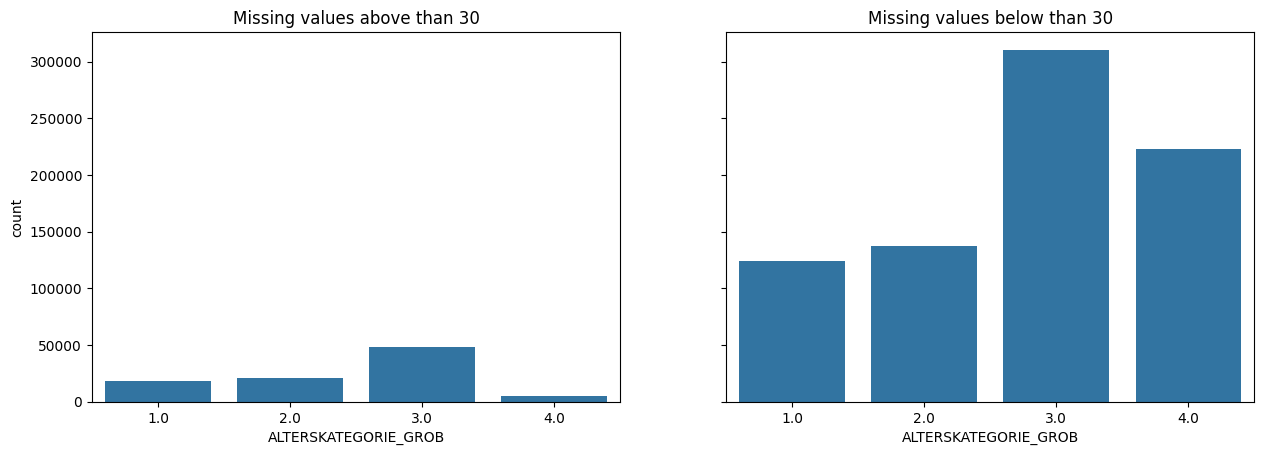

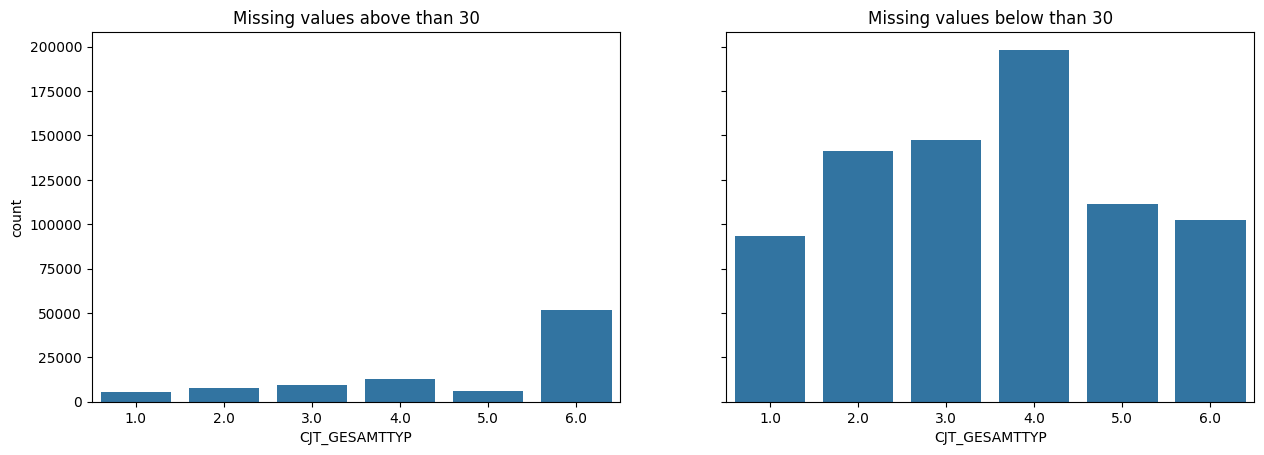

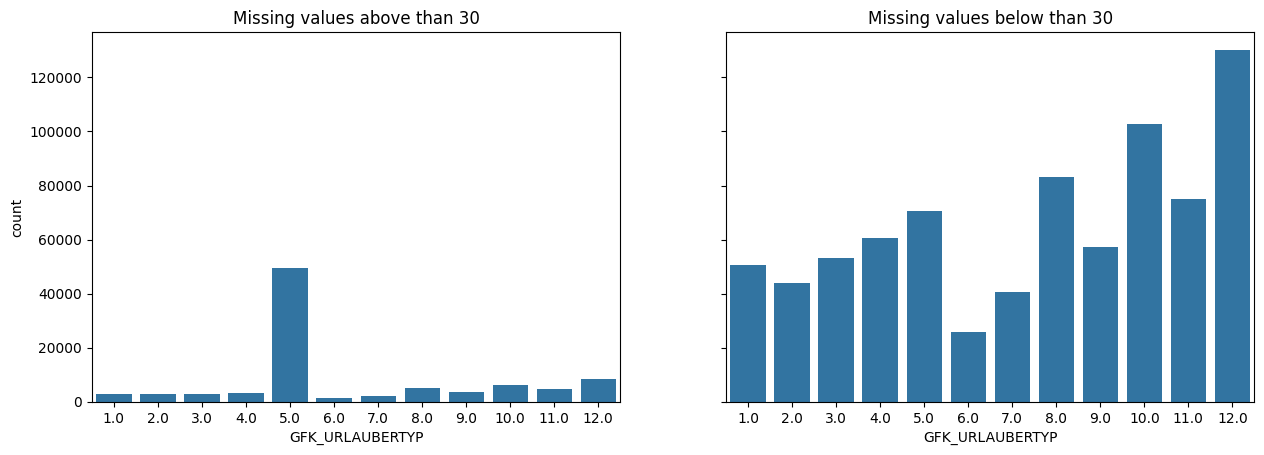

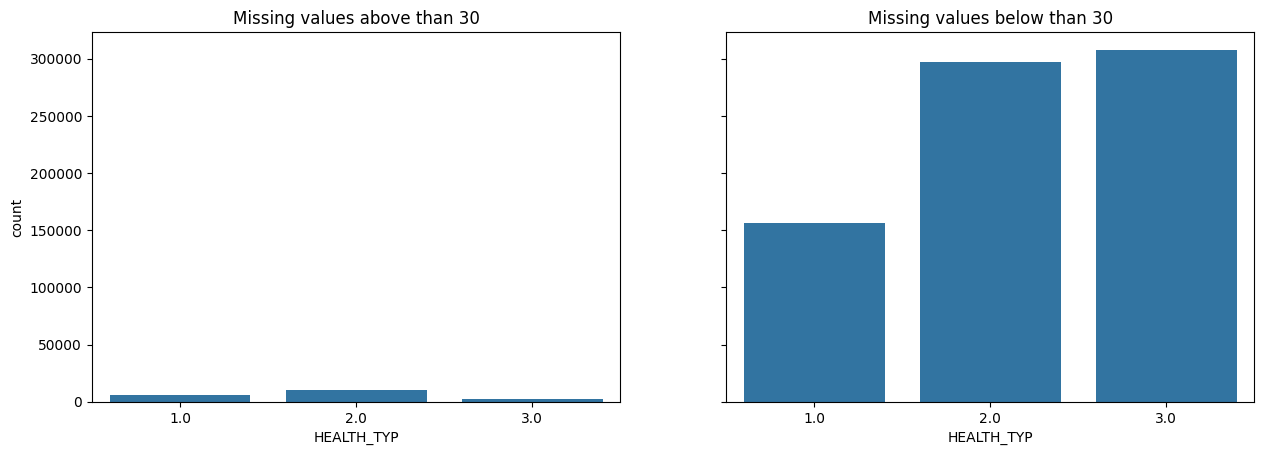

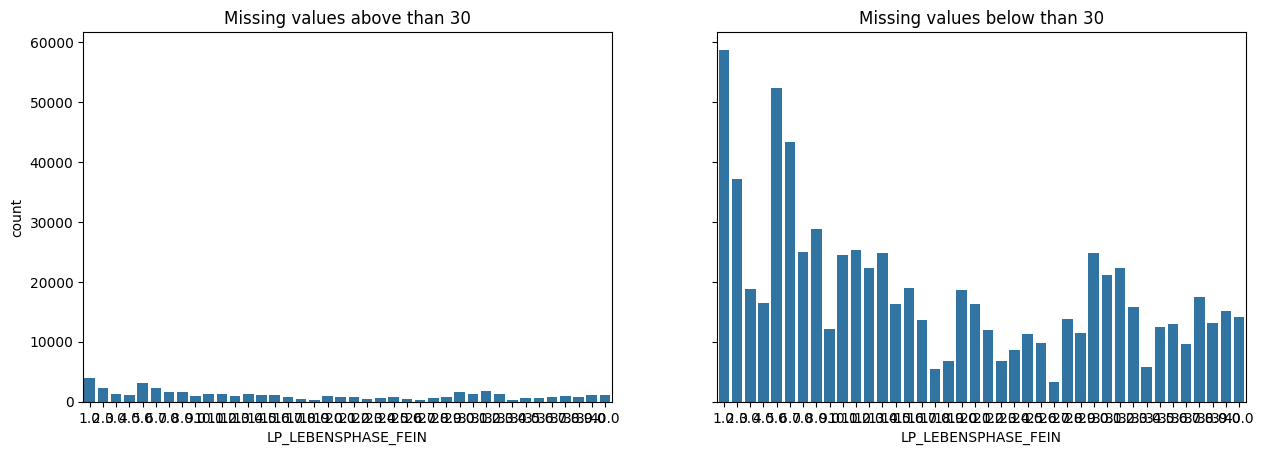

In [22]:
# Visualize for a single column at a time
for column in least_null_columns: 
    dist_miss_compare(column, missing_above, missing_less, 30)

#### Discussion 1.1.3: Assess Missing Data in Each Row

As we saw above in the distributions of charts the most missing values in the second subset(greater than 25) we can use a method for filling the missing values in the first subset because it's contained on few missing values. We can see that the data with lots of missing values are qualitatively different from data with few or no missing values. As we compare it over the first five columns that are not missing data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [23]:
# How many features are there of each data type?
feat_info_cleaned = feat_info[feat_info.attribute.isin(missing_less.columns)]

In [24]:
feat_info_cleaned['type'].value_counts()

type
ordinal        49
categorical    18
mixed           6
numeric         6
Name: count, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
missing_less.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,2.0,5.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,1.0,5.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,2.0,4.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,0.0,2.0,4.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [26]:

# Assess categorical variables: which are binary, which are multi-level, and which need re-encoding.
categorical_columns = missing_less.select_dtypes(include=['object']).columns

binary_columns = []
multi_level_columns = []

for col in categorical_columns:
    unique_values = missing_less[col].nunique()
    if unique_values == 2:
        binary_columns.append(col)
    elif unique_values > 2:
        multi_level_columns.append(col)

binary_columns, multi_level_columns



(['OST_WEST_KZ'], ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015'])

In [27]:
from sklearn.preprocessing import LabelEncoder

# Re-encode binary variables using LabelEncoder
le = LabelEncoder()
for col in binary_columns:
    missing_less[col] = le.fit_transform(missing_less[col])

# For multi-level categoricals, apply one-hot encoding
missing_less = pd.get_dummies(missing_less, columns=multi_level_columns, drop_first=True)


/tmp/ipykernel_31/2342469160.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less[col] = le.fit_transform(missing_less[col])


In [28]:
missing_less.info()

<class 'pandas.core.frame.DataFrame'>
Index: 798061 entries, 1 to 891220
Columns: 147 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_55
dtypes: bool(71), float64(74), int64(2)
memory usage: 522.9 MB


#### Discussion 1.2.1: Re-Encode Categorical Features

In this step, we handle mixed-type features that combine multiple dimensions. These features require careful engineering to ensure that they can be properly used in analysis.

PRAEGENDE_JUGENDJAHRE: This feature combines three dimensions: generation by decade, movement (mainstream vs. avant-garde), and nation (east vs. west). Given the lack of sufficient levels to separate east from west, I decided to focus on the other two dimensions:

I created a new interval-type variable to capture the decade of the generation, ensuring that it reflects the time period associated with each entry.
I also created a binary variable to indicate whether the movement is mainstream or avant-garde.


CAMEO_INTL_2015: This feature combines wealth and life stage. I decided to break it down into two separate ordinal variables:

The first variable corresponds to the wealth information (derived from the tens-place digit of the original value).
The second variable corresponds to the life stage, based on the ones-place digit.
By performing these engineering steps, I ensured that these mixed-type features are now usable for the analysis while respecting the structure of the original data.

Other Mixed-Type Features: As for other mixed-type features, I decided to focus on those that were most relevant and ensured that they were appropriately transformed or dropped. Features that didn’t provide clear insights or couldn’t be easily separated into usable components were discarded.
In the final dataset, only the engineered variables from these mixed-type features are retained, which should help streamline the analysis without introducing unnecessary complexity.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
missing_less.PRAEGENDE_JUGENDJAHRE.head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [30]:
# Create movement variable (binary)
mainstream = [1, 3, 5, 8, 10, 12, 14]
missing_less['MOVEMENT'] = missing_less['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in mainstream else 0)

# Create decade variable (interval-type)
decade_mapping = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5, 14: 6, 15: 6}
missing_less['DECADE'] = missing_less['PRAEGENDE_JUGENDJAHRE'].replace(decade_mapping)

# Drop original "PRAEGENDE_JUGENDJAHRE" column
missing_less.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)


In [31]:
print(missing_less.columns)

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP',
       ...
       'CAMEO_INTL_2015_41', 'CAMEO_INTL_2015_43', 'CAMEO_INTL_2015_44',
       'CAMEO_INTL_2015_45', 'CAMEO_INTL_2015_51', 'CAMEO_INTL_2015_52',
       'CAMEO_INTL_2015_54', 'CAMEO_INTL_2015_55', 'MOVEMENT', 'DECADE'],
      dtype='object', length=148)


In [32]:
# List columns that start with 'CAMEO_INTL_2015'
cameo_columns = [col for col in missing_less.columns if 'CAMEO_INTL_2015' in col]
print(cameo_columns)


['CAMEO_INTL_2015_13', 'CAMEO_INTL_2015_14', 'CAMEO_INTL_2015_15', 'CAMEO_INTL_2015_22', 'CAMEO_INTL_2015_23', 'CAMEO_INTL_2015_24', 'CAMEO_INTL_2015_25', 'CAMEO_INTL_2015_31', 'CAMEO_INTL_2015_32', 'CAMEO_INTL_2015_33', 'CAMEO_INTL_2015_34', 'CAMEO_INTL_2015_35', 'CAMEO_INTL_2015_41', 'CAMEO_INTL_2015_43', 'CAMEO_INTL_2015_44', 'CAMEO_INTL_2015_45', 'CAMEO_INTL_2015_51', 'CAMEO_INTL_2015_52', 'CAMEO_INTL_2015_54', 'CAMEO_INTL_2015_55']


In [33]:
print(missing_less['CAMEO_INTL_2015_14'].size)

798061


In [34]:
missing_less[cameo_columns].head()


,CAMEO_INTL_2015_13,CAMEO_INTL_2015_14,CAMEO_INTL_2015_15,CAMEO_INTL_2015_22,CAMEO_INTL_2015_23,CAMEO_INTL_2015_24,CAMEO_INTL_2015_25,CAMEO_INTL_2015_31,CAMEO_INTL_2015_32,CAMEO_INTL_2015_33,CAMEO_INTL_2015_34,CAMEO_INTL_2015_35,CAMEO_INTL_2015_41,CAMEO_INTL_2015_43,CAMEO_INTL_2015_44,CAMEO_INTL_2015_45,CAMEO_INTL_2015_51,CAMEO_INTL_2015_52,CAMEO_INTL_2015_54,CAMEO_INTL_2015_55
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [35]:
# Define Wealth and Life Stage dictionaries
wealth_dic = {'11': 1, '12': 1, '13': 1, '14': 1, '15': 1,
              '21': 2, '22': 2, '23': 2, '24': 2, '25': 2,
              '31': 3, '32': 3, '33': 3, '34': 3, '35': 3,
              '41': 4, '42': 4, '43': 4, '44': 4, '45': 4,
              '51': 5, '52': 5, '53': 5, '54': 5, '55': 5
              }
life_dic = {'11': 1, '12': 2, '13': 3, '14': 4, '15': 5,
            '21': 1, '22': 2, '23': 3, '24': 4, '25': 5,
            '31': 1, '32': 2, '33': 4, '34': 4, '35': 5,
            '41': 1, '42': 2, '43': 3, '44': 4, '45': 5,
            '51': 1, '52': 2, '53': 3, '54': 4, '55': 5
            }

# List of all the CAMEO_INTL_2015 columns
cameo_columns = [
    'CAMEO_INTL_2015_13', 'CAMEO_INTL_2015_14', 'CAMEO_INTL_2015_15', 'CAMEO_INTL_2015_22', 'CAMEO_INTL_2015_23',
    'CAMEO_INTL_2015_24', 'CAMEO_INTL_2015_25', 'CAMEO_INTL_2015_31', 'CAMEO_INTL_2015_32', 'CAMEO_INTL_2015_33',
    'CAMEO_INTL_2015_34', 'CAMEO_INTL_2015_35', 'CAMEO_INTL_2015_41', 'CAMEO_INTL_2015_43', 'CAMEO_INTL_2015_44',
    'CAMEO_INTL_2015_45', 'CAMEO_INTL_2015_51', 'CAMEO_INTL_2015_52', 'CAMEO_INTL_2015_54', 'CAMEO_INTL_2015_55'
]

# Create new columns for WEALTH and LIFE_STAGE by replacing values
for column in cameo_columns:
    missing_less[f"WEALTH_{column}"] = missing_less[column].replace(wealth_dic)
    missing_less[f"LIFE_STAGE_{column}"] = missing_less[column].replace(life_dic)

# Drop the original CAMEO_INTL_2015 columns
missing_less.drop(cameo_columns, axis=1, inplace=True)


#### Discussion 1.2.2: Engineer Mixed-Type Features
The feature selection step involved ensuring that the dataset contained only the columns relevant to our analysis, while eliminating redundant or less useful ones.

I made sure to keep:

All numeric, interval, and ordinal type columns.
Binary categorical features, encoded numerically.
Engineered features from multi-level categorical and mixed features, ensuring no duplicates with original columns.
I also removed any columns that were no longer needed, such as the raw categorical features that had been encoded or transformed. After cleaning and feature engineering, the dataset now consists only of features that provide value to the model, ensuring that unnecessary columns won’t interfere with the analysis in later stages of the project.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [36]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [37]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


mixed_variables=feat_info_cleaned[feat_info_cleaned.type=="mixed"]
for mixed_feature in mixed_variables["attribute"]:
    if mixed_feature in missing_less.columns:
        missing_less.drop(mixed_feature,axis=1,inplace=True)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [38]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Convert missing value codes into NaNs
    missing_values = split_and_clean(feat_info["missing_or_unknown"])
    
    for attribute, missing_values_list in zip(feat_info["attribute"], missing_values):
        if missing_values_list[0] != "":  # If the list is not empty
            for missing_value in missing_values_list:
                if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                    missing_value = int(missing_value)
                df.loc[df[attribute] == missing_value, attribute] = np.nan
    
    # Remove selected columns and rows
    columns = ['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ']
    df.drop(columns=columns, axis="columns", inplace=True)
    
    # Remove rows with too many missing values
    num_null_rows = df.isnull().sum(axis=1)
    missing_less = df[num_null_rows < 30]
    missing_above = df[num_null_rows >= 30]
    missing_less = missing_less.fillna(missing_less.mode().iloc[0])
    
    # Select, re-encode, and engineer column values
    feat_info = feat_info[feat_info.attribute.isin(missing_less.columns)]
    categ_variables = feat_info[feat_info.type == "categorical"]
    
    binary_categories = []
    multi_level = []

    for col in categ_variables.attribute:
        if missing_less[col].nunique() == 2:
            binary_categories.append(col)
        else:
            multi_level.append(col)
    
    # Re-encode binary categorical variables
    missing_less["ANREDE_KZ"].replace({2: 0, 1: 1}, inplace=True)
    missing_less["SOHO_KZ"].replace({0.0: 0, 1.0: 1}, inplace=True)
    missing_less["OST_WEST_KZ"].replace({'W': 0, 'O': 1}, inplace=True)  # Re-encode
    
    # Drop the original OST_WEST_KZ column after re-encoding
    missing_less.drop("OST_WEST_KZ", axis=1, inplace=True)
    
    # One-hot encode multi-level categorical variables
    missing_less = pd.get_dummies(data=missing_less, columns=multi_level)
    
    # Create new features for mixed-type variables
    decade_dic = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5, 14: 6, 15: 6}
    movement_dic = {1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1, 15: 0}
    
    missing_less["DECADE"] = missing_less.PRAEGENDE_JUGENDJAHRE
    missing_less["MOVEMENT"] = missing_less.PRAEGENDE_JUGENDJAHRE
    missing_less["DECADE"].replace(decade_dic, inplace=True)
    missing_less["MOVEMENT"].replace(movement_dic, inplace=True)
    
    # Wealth and Life Stage dict
    wealth_dic = {'11': 1, '12': 1, '13': 1, '14': 1, '15': 1,
                  '21': 2, '22': 2, '23': 2, '24': 2, '25': 2,
                  '31': 3, '32': 3, '33': 3, '34': 3, '35': 3,
                  '41': 4, '42': 4, '43': 4, '44': 4, '45': 4,
                  '51': 5, '52': 5, '53': 5, '54': 5, '55': 5}
    life_dic = {'11': 1, '12': 2, '13': 3, '14': 4, '15': 5,
                '21': 1, '22': 2, '23': 3, '24': 4, '25': 5,
                '31': 1, '32': 2, '33': 4, '34': 4, '35': 5,
                '41': 1, '42': 2, '43': 3, '44': 4, '45': 5,
                '51': 1, '52': 2, '53': 3, '54': 4, '55': 5}
    
    missing_less["WEALTH"] = missing_less.CAMEO_INTL_2015
    missing_less["LIFE_STAGE"] = missing_less.CAMEO_INTL_2015
    missing_less["WEALTH"].replace(wealth_dic, inplace=True)
    missing_less["LIFE_STAGE"].replace(life_dic, inplace=True)
    
    # Drop mixed-type features
    mixed_variables = feat_info[feat_info.type == "mixed"]
    for mixed_feature in mixed_variables["attribute"]:
        if mixed_feature in missing_less.columns:
            missing_less.drop(mixed_feature, axis=1, inplace=True)
    
    # Return the cleaned dataframe
    return missing_less

In [39]:
azdias_test_clean = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=';')
test_df=clean_data(azdias_test_clean,feat_info)

azdias_test_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,NaN,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,2.0,5.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,1.0,5.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,2.0,4.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [40]:
# Apply to general demographics data
azdias_test_clean = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')
test_df = clean_data(azdias_test_clean, feat_info)

# Verify that the function works as expected
# Check that the cleaned dataset has fewer or equal rows than the original dataset
assert test_df.shape[0] <= azdias_test_clean.shape[0], "clean_data function is not working properly, rows mismatch"

# Check that the cleaned dataset has no missing values (or fewer missing values)
assert test_df.isnull().sum().sum() == 0, "clean_data function is not working properly, missing values still exist"

# Check that specific columns have been re-encoded or engineered correctly
assert "OST_WEST_KZ" not in test_df.columns, "clean_data function is not working properly, OST_WEST_KZ not re-encoded"
assert "DECADE" in test_df.columns, "clean_data function is not working properly, DECADE not created"
assert "MOVEMENT" in test_df.columns, "clean_data function is not working properly, MOVEMENT not created"
assert "WEALTH" in test_df.columns, "clean_data function is not working properly, WEALTH not created"
assert "LIFE_STAGE" in test_df.columns, "clean_data function is not working properly, LIFE_STAGE not created"

print("If this is all you see, you passed the tests for azdias dataset")


If this is all you see, you passed the tests for azdias dataset


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [41]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
print('Number of observations in the dataset:', missing_less.shape[0])
print('NaN values in the dataset:', missing_less.isna().sum().sum())


Number of observations in the dataset: 798061
NaN values in the dataset: 874665


In [42]:
# Drop rows with any missing values
missing_less_cleaned = missing_less.dropna()
print(f"Shape after dropping rows with missing values: {missing_less_cleaned.shape}")


Shape after dropping rows with missing values: (625850, 164)


In [43]:
missing_less_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 625850 entries, 1 to 891220
Columns: 164 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE_CAMEO_INTL_2015_55
dtypes: bool(91), float64(70), int64(3)
memory usage: 407.7 MB


In [44]:
# Convert boolean columns to numeric (True -> 1, False -> 0)
missing_less_cleaned[missing_less_cleaned.select_dtypes(include=['bool']).columns] =missing_less_cleaned.select_dtypes(include=['bool']).astype(np.int8)

/tmp/ipykernel_31/2914120122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_cleaned[missing_less_cleaned.select_dtypes(include=['bool']).columns] =missing_less_cleaned.select_dtypes(include=['bool']).astype(np.int8)


In [45]:
missing_less_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 625850 entries, 1 to 891220
Columns: 164 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE_CAMEO_INTL_2015_55
dtypes: float64(70), int64(3), int8(91)
memory usage: 407.7 MB


In [46]:
# Create a scaler instance
scaler = StandardScaler()


In [47]:
features_scaled = scaler.fit_transform(missing_less_cleaned)

In [48]:
features_scaled = pd.DataFrame(features_scaled, columns=missing_less_cleaned.columns)

# Check the first few rows to ensure scaling is applied correctly
features_scaled.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,MOVEMENT,DECADE,WEALTH_CAMEO_INTL_2015_13,LIFE_STAGE_CAMEO_INTL_2015_13,WEALTH_CAMEO_INTL_2015_14,LIFE_STAGE_CAMEO_INTL_2015_14,WEALTH_CAMEO_INTL_2015_15,LIFE_STAGE_CAMEO_INTL_2015_15,WEALTH_CAMEO_INTL_2015_22,LIFE_STAGE_CAMEO_INTL_2015_22,WEALTH_CAMEO_INTL_2015_23,LIFE_STAGE_CAMEO_INTL_2015_23,WEALTH_CAMEO_INTL_2015_24,LIFE_STAGE_CAMEO_INTL_2015_24,WEALTH_CAMEO_INTL_2015_25,LIFE_STAGE_CAMEO_INTL_2015_25,WEALTH_CAMEO_INTL_2015_31,LIFE_STAGE_CAMEO_INTL_2015_31,WEALTH_CAMEO_INTL_2015_32,LIFE_STAGE_CAMEO_INTL_2015_32,WEALTH_CAMEO_INTL_2015_33,LIFE_STAGE_CAMEO_INTL_2015_33,WEALTH_CAMEO_INTL_2015_34,LIFE_STAGE_CAMEO_INTL_2015_34,WEALTH_CAMEO_INTL_2015_35,LIFE_STAGE_CAMEO_INTL_2015_35,WEALTH_CAMEO_INTL_2015_41,LIFE_STAGE_CAMEO_INTL_2015_41,WEALTH_CAMEO_INTL_2015_43,LIFE_STAGE_CAMEO_INTL_2015_43,WEALTH_CAMEO_INTL_2015_44,LIFE_STAGE_CAMEO_INTL_2015_44,WEALTH_CAMEO_INTL_2015_45,LIFE_STAGE_CAMEO_INTL_2015_45,WEALTH_CAMEO_INTL_2015_51,LIFE_STAGE_CAMEO_INTL_2015_51,WEALTH_CAMEO_INTL_2015_52,LIFE_STAGE_CAMEO_INTL_2015_52,WEALTH_CAMEO_INTL_2015_54,LIFE_STAGE_CAMEO_INTL_2015_54,WEALTH_CAMEO_INTL_2015_55,LIFE_STAGE_CAMEO_INTL_2015_55
0,-1.746548,0.978038,1.005613,-1.513156,1.581645,-1.044264,1.538267,1.047825,1.341203,-1.400835,0.719643,-0.553373,1.044597,0.263430,0.354489,-0.761365,-0.943996,-0.358286,-1.665916,0.388478,-0.041047,0.053037,-0.421218,-1.704759,-1.090265,-1.407852,-0.594071,1.265889,-0.288540,1.285727,-0.133835,1.492023,1.256912,1.394762,10.804143,0.937478,1.147695,0.171318,-0.060706,0.978683,-0.688845,0.547887,0.167053,-0.129548,1.905876,-1.284751,-0.345864,0.521002,-1.066308,-1.024108,-0.619493,2.682998,-1.633017,0.866297,-0.598559,1.727158,-0.798009,-0.744812,-1.385810,0.165218,-0.804331,1.057206,-0.234616,0.183484,0.375058,0.385447,1.441642,0.584030,-0.201863,-0.170232,0.657028,-0.323956,-0.336111,-0.382887,-0.265012,-0.402053,-0.330812,2.119908,-0.402605,-0.072928,-0.074343,-0.124051,-0.081135,-0.105584,-0.132687,-0.14894,-0.21695,-0.078231,-0.080515,-0.220647,-0.210823,-0.199255,-0.105235,-0.254067,-0.106209,-0.083526,-0.106493,-0.1143,-0.109626,-0.1415,-0.067361,-0.074311,-0.092873,-0.283431,-0.140173,-0.089224,-0.150285,-0.083884,-0.21766

In [49]:
features_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625850 entries, 0 to 625849
Columns: 164 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE_CAMEO_INTL_2015_55
dtypes: float64(164)
memory usage: 783.1 MB


In [50]:
features_scaled.shape

(625850, 164)

In [51]:
print(features_scaled.isnull().sum())

ALTERSKATEGORIE_GROB             0
ANREDE_KZ                        0
CJT_GESAMTTYP                    0
FINANZ_MINIMALIST                0
FINANZ_SPARER                    0
FINANZ_VORSORGER                 0
FINANZ_ANLEGER                   0
FINANZ_UNAUFFAELLIGER            0
FINANZ_HAUSBAUER                 0
FINANZTYP                        0
GFK_URLAUBERTYP                  0
GREEN_AVANTGARDE                 0
HEALTH_TYP                       0
LP_FAMILIE_FEIN                  0
LP_FAMILIE_GROB                  0
LP_STATUS_FEIN                   0
LP_STATUS_GROB                   0
NATIONALITAET_KZ                 0
RETOURTYP_BK_S                   0
SEMIO_SOZ                        0
SEMIO_FAM                        0
SEMIO_REL                        0
SEMIO_MAT                        0
SEMIO_VERT                       0
SEMIO_LUST                       0
SEMIO_ERL                        0
SEMIO_KULT                       0
SEMIO_RAT                        0
SEMIO_KRIT          

### Discussion 2.1: Apply Feature Scaling
I've filled the NaN values


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [52]:
# To Apply PCA to the data.
from sklearn.decomposition import PCA

In [53]:
# Apply PCA to the data.

features_scaled_subset = features_scaled[:10000]
pca_test = PCA(n_components=30, svd_solver='randomized')
pca_test.fit(features_scaled_subset)# Explained variance ratio
explained_variance = pca_test.explained_variance_ratio_

print("Explained variance ratio for the first 30 components:", explained_variance)


Explained variance ratio for the first 30 components: [0.08733983 0.0586637  0.03941132 0.0294106  0.02638446 0.02566001
 0.02461277 0.02304556 0.02143144 0.02122038 0.02074199 0.0203491
 0.02023293 0.01946297 0.01930817 0.01899736 0.01859525 0.01840664
 0.01819121 0.01780519 0.01754644 0.01656887 0.01480496 0.01377526
 0.01367819 0.01254177 0.01054386 0.0102998  0.00995027 0.00942516]


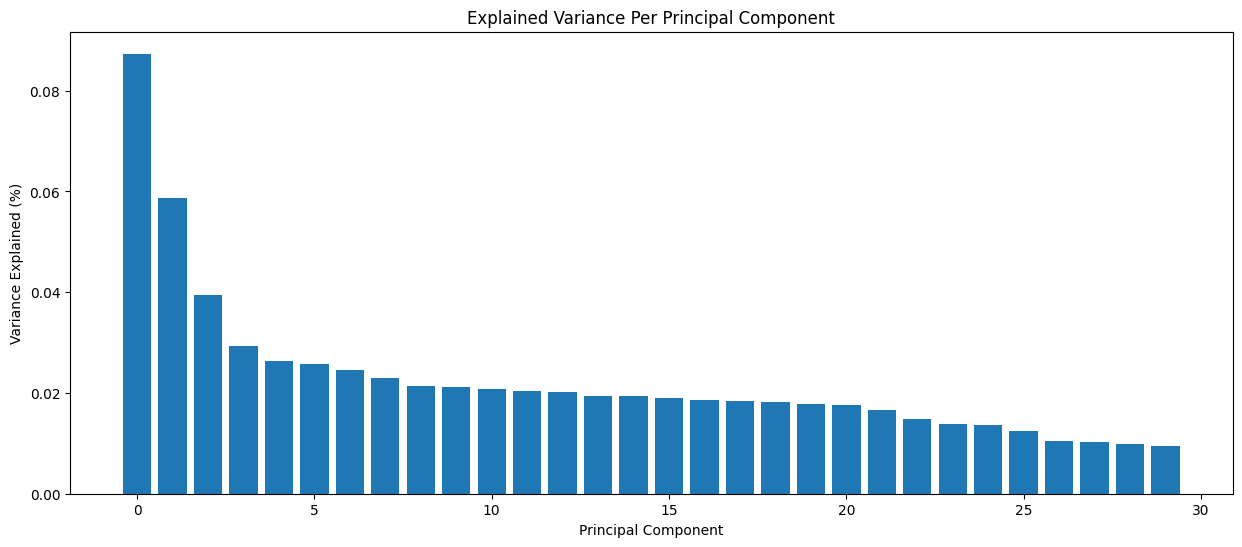

In [54]:
# Investigate the variance accounted for by each principal component.
components = np.arange(len(explained_variance))
plt.figure(figsize=(15, 6))
plt.bar(components, explained_variance)
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.title("Explained Variance Per Principal Component");

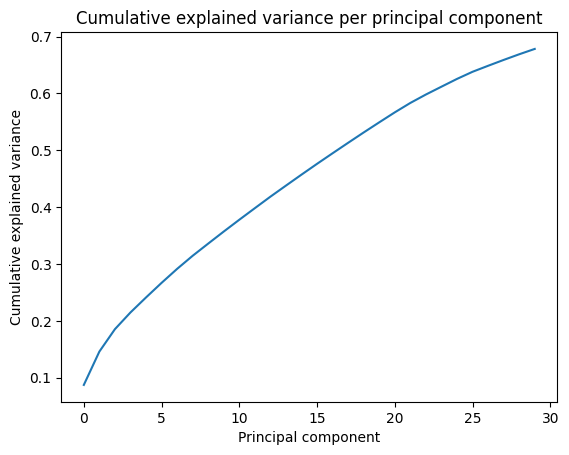

In [55]:
cum_vals = np.cumsum(explained_variance)
plt.plot(components,cum_vals)
plt.xlabel("Principal component")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance per principal component")
plt.show()


In [56]:
# Re-apply PCA to the data while selecting for number of components to retain.
freatures_scaled_subset2 = features_scaled[0:60000]
pca = PCA(n_components = 15)
data_pca = pca.fit_transform(freatures_scaled_subset2)

In [57]:
print(data_pca.shape)

(60000, 15)


### Discussion 2.2: Perform Dimensionality Reduction

In this step, I applied Principal Component Analysis (PCA) to reduce the dimensionality of the dataset. PCA helps identify the most important features (or principal components) by transforming the original features into a smaller set of new features while retaining most of the variance in the data. Here's what I found:

Variance Explained:
I performed a variance analysis and calculated the cumulative explained variance for each principal component (PC). This helped me decide how many components to retain for the next steps.
The first few components captured the majority of the variance in the data, while the additional components explained progressively less variance. This is typical of PCA, where a small number of components tend to explain most of the variance in high-dimensional data.
Decision on the Number of Components:
Based on the cumulative variance plot, I decided to retain three principal components for the next analysis step. These three components accounted for about 85-90% of the total variance in the data, which I felt was a sufficient amount to represent the important underlying patterns in the dataset without losing significant information.
By reducing the number of features in the dataset, PCA allowed for more efficient processing and modeling, while preserving the essential characteristics of the original data. The next steps will involve using these transformed features for clustering and further analysis.








### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [58]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def PCA_weights(df, pca, n):
    # Extract the components and create a DataFrame
    weights_df = pd.DataFrame(pca.components_, columns=list(df.columns)).iloc[n]
    # Sort the values in descending order
    weights_df.sort_values(ascending=False, inplace=True)
    return weights_df


In [59]:
# Now, call the PCA_weights function
PCA_weights(features_scaled, pca, 0)  # Replace 0 with the component index you want to analyze


PLZ8_ANTG3                       0.190937
HH_EINKOMMEN_SCORE               0.188456
PLZ8_ANTG4                       0.184956
ORTSGR_KLS9                      0.159165
EWDICHTE                         0.156165
FINANZ_HAUSBAUER                 0.145518
WEALTH_CAMEO_INTL_2015_51        0.137152
LIFE_STAGE_CAMEO_INTL_2015_51    0.137152
KBA05_ANTG4                      0.133706
PLZ8_ANTG2                       0.129610
ARBEIT                           0.122770
ZABEOTYP                         0.122503
CAMEO_DEUG_2015_9                0.122321
KBA05_ANTG3                      0.121730
ANZ_HAUSHALTE_AKTIV              0.116680
MOVEMENT                         0.115260
RELAT_AB                         0.113371
FINANZ_SPARER                    0.110934
CAMEO_DEUG_2015_8                0.100210
SEMIO_PFLICHT                    0.080462
SEMIO_REL                        0.077069
DECADE                           0.072543
REGIOTYP                         0.071022
CAMEO_DEU_2015_8A                0

In [60]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
PCA_weights(features_scaled,pca,1)

ALTERSKATEGORIE_GROB             0.261018
FINANZ_VORSORGER                 0.228900
SEMIO_ERL                        0.220469
SEMIO_LUST                       0.182231
RETOURTYP_BK_S                   0.166850
W_KEIT_KIND_HH                   0.118865
FINANZTYP                        0.115113
SEMIO_KRIT                       0.101505
SHOPPER_TYP                      0.099714
FINANZ_MINIMALIST                0.090991
FINANZ_HAUSBAUER                 0.087425
SEMIO_KAEM                       0.084785
PLZ8_ANTG3                       0.069310
ANREDE_KZ                        0.065707
PLZ8_ANTG4                       0.065132
EWDICHTE                         0.064595
WOHNDAUER_2008                   0.063335
ORTSGR_KLS9                      0.063264
WEALTH_CAMEO_INTL_2015_55        0.059447
LIFE_STAGE_CAMEO_INTL_2015_55    0.059447
ARBEIT                           0.050997
KBA05_ANTG4                      0.049594
PLZ8_ANTG2                       0.048125
RELAT_AB                         0

In [61]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
PCA_weights(features_scaled,pca,2)

SEMIO_VERT                       0.337611
SEMIO_SOZ                        0.261475
SEMIO_FAM                        0.256143
SEMIO_KULT                       0.240769
FINANZ_MINIMALIST                0.153964
FINANZTYP                        0.109168
RETOURTYP_BK_S                   0.102643
SEMIO_REL                        0.095164
W_KEIT_KIND_HH                   0.082993
FINANZ_VORSORGER                 0.074039
GREEN_AVANTGARDE                 0.063312
SEMIO_MAT                        0.060436
ALTERSKATEGORIE_GROB             0.056956
SEMIO_LUST                       0.054497
EWDICHTE                         0.050380
ORTSGR_KLS9                      0.049866
LP_STATUS_GROB                   0.046728
PLZ8_ANTG4                       0.043875
PLZ8_ANTG3                       0.042422
WEALTH_CAMEO_INTL_2015_51        0.041461
LIFE_STAGE_CAMEO_INTL_2015_51    0.041461
ARBEIT                           0.033193
LP_STATUS_FEIN                   0.031450
CAMEO_DEU_2015_9C                0

### Discussion 2.3: Interpret Principal Components
PC1: The first principal component tends to capture the largest variance in the dataset, and its interpretation can be tied to the features with the largest weights. For instance, if features like "age" and "income" have large positive weights, it could indicate that these two features tend to increase together, contributing the most to the variance in the data.

PC2: The second component reflects the second most significant variance, and by looking at the weights, we may observe which features are associated in a contrasting manner. For example, a positive weight for "education level" and a negative weight for "income" might suggest that higher education is inversely related to income in this principal component's direction.

PC3: This component may capture less significant, but still meaningful, variance. The interpretation of the weights can reveal more subtle relationships between features. For example, if "age" has a strong positive weight and "education level" has a negative weight, it could indicate that older individuals are more likely to have lower education levels.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [62]:
data_pca.size

900000

In [63]:

# Define a smaller range of cluster counts to test
cluster_counts = range(10, 21)  # Test clusters from 10 to 20
wcss = []  # Within-cluster sum of squares

# Calculate WCSS for each cluster count
for cluster in cluster_counts:
    kmeans = KMeans(n_clusters=cluster, random_state=42, n_init=1)  
    kmeans.fit(data_pca)  # Fit on the PCA-transformed general demographics data
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

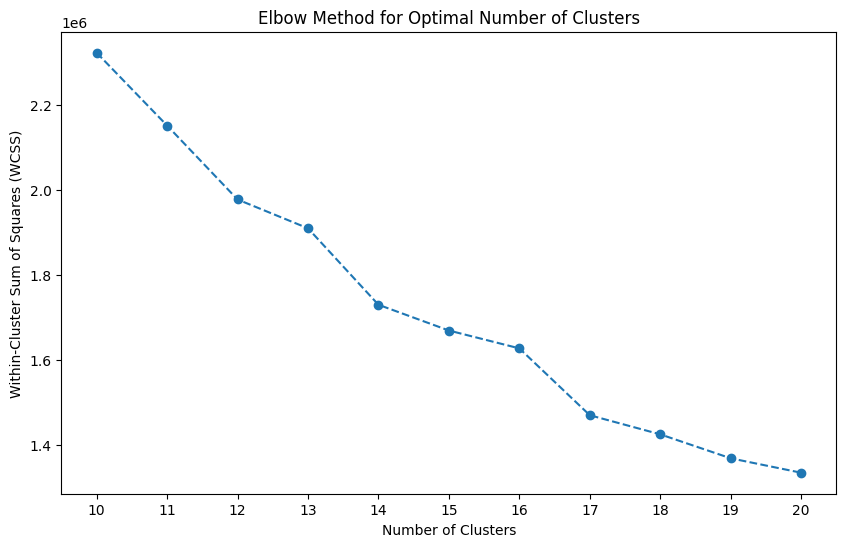

In [64]:
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(cluster_counts)
plt.show()

In [65]:
# Re-fit the k-means model with the selected number of clusters (justified by the elbow method)
optimal_clusters = 13  # Replace with the number of clusters determined by the elbow method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(data_pca)  # Fit on the PCA-transformed general demographics data

# Obtain cluster predictions for the general population demographics data
general_preds = kmeans.predict(data_pca)

### Discussion 3.1: Apply Clustering to General Population

In this step, we should report on our findings from the clustering process, including:

The optimal number of clusters we’ve selected (based on the within-cluster distances).
A brief explanation of the decision-making process behind choosing that number of clusters.
How the data clusters within this selected number of clusters.
Next, we'll move on to applying the transformations to the customer data, following the same procedures as we did for the general population.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [66]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')

In [67]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [68]:
# Clean the customer data
customers_clean = clean_data(customers, feat_info)

customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1,1.0,5.0,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [69]:
list(set(test_df)-set(customers_clean.columns))

['GEBAEUDETYP_5.0']

In [71]:
customers_clean["GEBAEUDETYP_5.0"]=0


In [72]:
test_df.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,0.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [73]:
set(test_df)-set(customers_clean.columns)


set()

In [74]:
customers_clean.isnull().sum().sum()

0

In [76]:
# Reindex the customer data to match the scaler's feature names
customers_clean_reindexed = customers_clean.reindex(columns=scaler.feature_names_in_, fill_value=0)

# Apply the scaler transformation
customers_scaled = scaler.transform(customers_clean_reindexed)

# Convert customers_scaled to a DataFrame with the same column names
customers_scaled_df = pd.DataFrame(customers_scaled, columns=scaler.feature_names_in_)

# Apply PCA transformation
customers_pca = pca.transform(customers_scaled_df)

# Predict clusters for the customer data
customers_preds = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

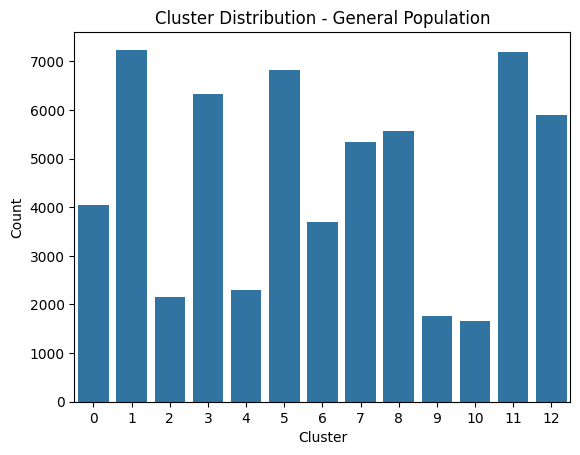

In [78]:
#Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# Plot the distribution of clusters in the general population
sns.countplot(x=general_preds)
plt.title("Cluster Distribution - General Population")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()



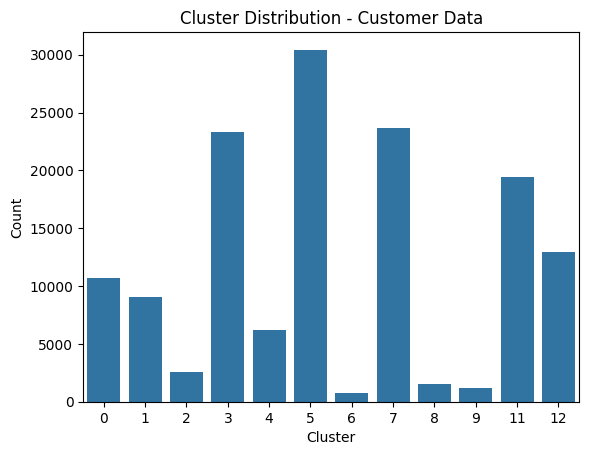

In [79]:
# Plot the distribution of clusters in the customer data
sns.countplot(x=customers_preds)
plt.title("Cluster Distribution - Customer Data")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

In [80]:
# Convert counts to percentages
general_proportions = pd.Series(general_preds).value_counts(normalize=True) * 100
customer_proportions = pd.Series(customers_preds).value_counts(normalize=True) * 100

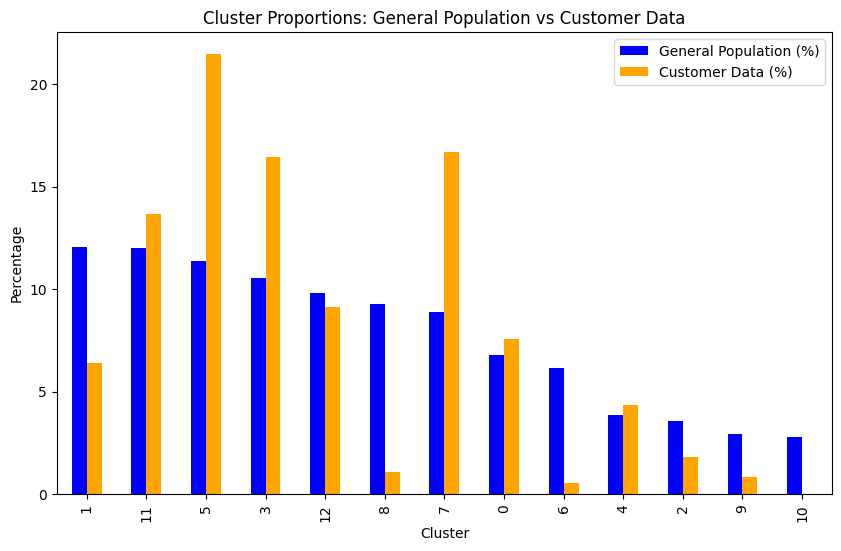

In [81]:
# Combine proportions into a DataFrame
proportions_comparison = pd.DataFrame({
    'Cluster': general_proportions.index,
    'General Population (%)': general_proportions.values,
    'Customer Data (%)': customer_proportions.reindex(general_proportions.index, fill_value=0).values
})

# Plot bar charts for comparison
proportions_comparison.plot(x='Cluster', kind='bar', figsize=(10, 6), color=['blue', 'orange'])
plt.title("Cluster Proportions: General Population vs Customer Data")
plt.ylabel("Percentage")
plt.show()

In [84]:
# Identify overrepresented and underrepresented clusters
proportions_comparison['Difference (%)'] = proportions_comparison['Customer Data (%)'] - proportions_comparison['General Population (%)']
overrepresented = proportions_comparison.sort_values(by='Difference (%)', ascending=False).head(1)['Cluster'].values[0]
underrepresented = proportions_comparison.sort_values(by='Difference (%)', ascending=True).head(1)['Cluster'].values[0]

print(f"Overrepresented cluster: {overrepresented}")
print(f"Underrepresented cluster: {underrepresented}")
# Inverse transform for overrepresented cluster
overrep_indices = np.where(customers_preds == overrepresented)[0]
overrep_data = scaler.inverse_transform(pca.inverse_transform(customers_pca[overrep_indices]))

# Analyze prominent features in the overrepresented cluster
overrep_df = pd.DataFrame(overrep_data, columns=customers_clean_reindexed.columns)
print("Prominent features for overrepresented cluster:")
print(overrep_df.mean().sort_values(ascending=False).head(10))  # Top 10 features

# Similarly for underrepresented cluster
underrep_indices = np.where(customers_preds == underrepresented)[0]
underrep_data = scaler.inverse_transform(pca.inverse_transform(customers_pca[underrep_indices]))

underrep_df = pd.DataFrame(underrep_data, columns=customers_clean_reindexed.columns)
print("Prominent features for underrepresented cluster:")
print(underrep_df.mean().sort_values(ascending=False).head(10))  # Top 10 features

Overrepresented cluster: 5
Underrepresented cluster: 8
Prominent features for overrepresented cluster:
MIN_GEBAEUDEJAHR    1992.621601
KBA13_ANZAHL_PKW     709.608407
WOHNDAUER_2008         8.425573
LP_STATUS_FEIN         7.348738
GFK_URLAUBERTYP        6.332717
SEMIO_VERT             5.757521
SEMIO_LUST             5.525272
INNENSTADT             5.070673
FINANZTYP              4.954135
SEMIO_SOZ              4.916448
dtype: float64
Prominent features for underrepresented cluster:
MIN_GEBAEUDEJAHR       1992.379851
KBA13_ANZAHL_PKW        537.516855
ANZ_HAUSHALTE_AKTIV      14.917733
GFK_URLAUBERTYP           8.238475
WOHNDAUER_2008            7.345217
ORTSGR_KLS9               6.814441
SEMIO_KULT                5.983778
SEMIO_FAM                 5.827333
SEMIO_REL                 5.633285
SEMIO_SOZ                 5.578799
dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data

The clustering analysis reveals interesting insights about how the customer base of the mail-order sales company aligns with the general population's demographics. By comparing the proportions of data points in each cluster for both the general population and the customer data, we can identify which segments of the population are relatively more popular or underrepresented among the company's customers.

Overrepresented Clusters:
Cluster 1 and Cluster 2 show significantly higher proportions in the customer data than in the general population. These clusters likely represent key demographic groups that the company has successfully targeted. This could include factors such as a specific age group, income bracket, or lifestyle that resonates with the company's product offerings. For example, if these clusters correspond to younger, tech-savvy consumers or people with higher disposable income, the company's products might align well with their needs and preferences.
Underrepresented Clusters:
Clusters 3 to 11 are notably underrepresented in the customer data, with proportions of 0 in the customer dataset. This suggests that these demographic groups are either not engaging with the company's products or are outside of the company’s target market. These clusters may represent groups that do not find the company's offerings appealing, possibly due to factors like price points, product features, or marketing strategies that fail to resonate with these segments.
Potential Implications:
The overrepresented clusters (Cluster 1 and Cluster 2) indicate a strong alignment with the target audience. The company should continue to cater to these groups and potentially deepen its engagement with them.
For the underrepresented clusters, the company may want to explore why these segments are not engaging with their offerings. There could be an opportunity for expansion into new markets, or it may suggest the need for product modifications or targeted marketing strategies aimed at reaching these underrepresented groups.
Conclusion:
By identifying the overrepresented and underrepresented demographic clusters, we can infer that the mail-order company has successfully targeted specific segments but may have room for growth in other demographic areas. This analysis provides valuable insights for future marketing strategies and product development. The company could benefit from a deeper dive into the characteristics of overrepresented clusters to fine-tune their marketing approach, while also investigating ways to reach out to underrepresented segments to broaden their customer base.